## Camera Calibration
OpenCV has provided a method to calculate the correct camera matrix and distortion coefficients using the calibration chessboard images. The following code snippet uses the chessboard images (9x6) in repository to calibrate the camera. Example code opencv2.org has been modified to fit new chessboard size.

In [1]:
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def calibrate_camera():
    """
    Calibrate camera using pre-captured images
    https://docs.opencv2.org/3.4.0/dc/dbb/tutorial_py_calibration.html
    """
    nx = 6
    ny = 9
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    images = glob.glob('camera_cal/calibration*.jpg')
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist
    
def undistort(img, mtx, dist):
    """Undistort an image using camera matrix and distortion coefficients"""
    h,  w = img.shape[:2]
    # return undistorted image with minimum unwanted pixels. It's okay to remove some pixesl at image corners.
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 0, (w,h))    
    undist = cv2.undistort(img, mtx, dist, None, newcameramtx)
    return undist
    
def test_calibration(mtx, dist, filename):
    """Util function to test camera calibration"""
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist = undistort(img, mtx, dist)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original {}'.format(filename), fontsize=20)
    ax2.imshow(undist)
    ax2.set_title('Undistorted', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

#### Test calibration on the selected images

It is evident that camera distortion in `camera_cal/calibration1.jpg` and `camera_cal/calibration2.jpg` has been successfully corrected.

We should be confident that the calibrated camera will help us reduce the errors in lane detection and radius curvature calculation.

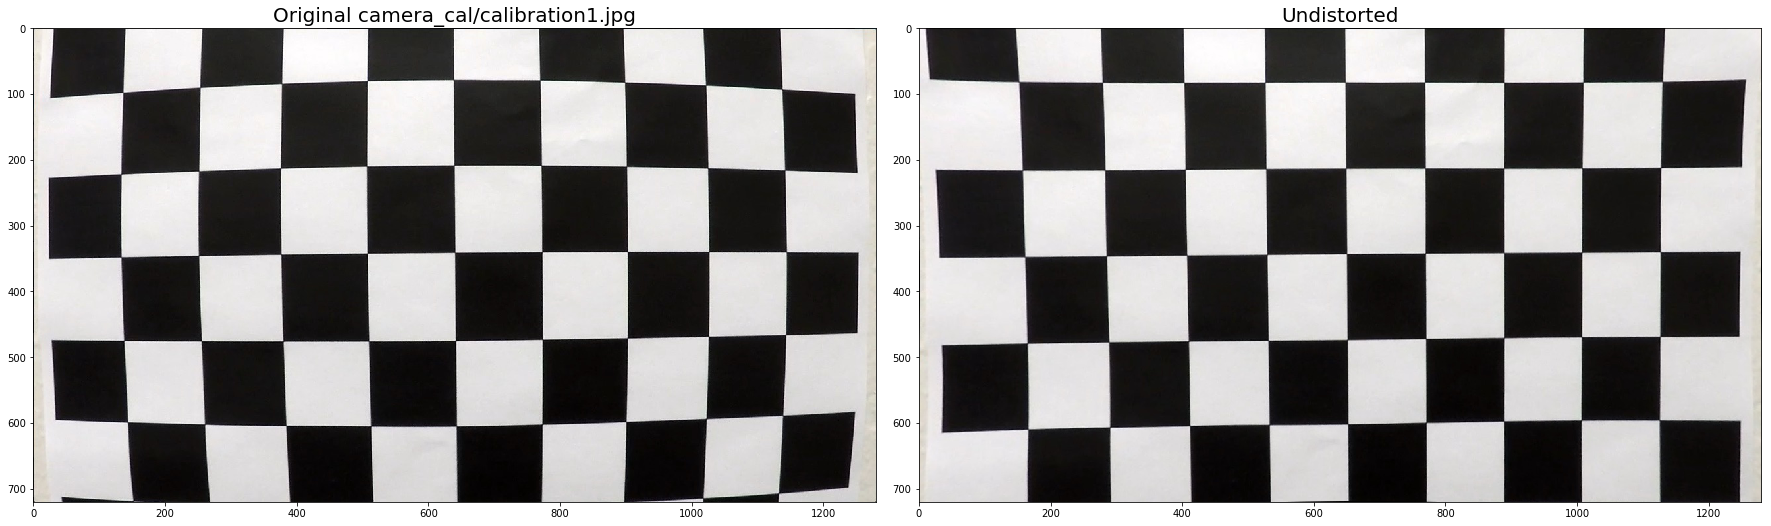

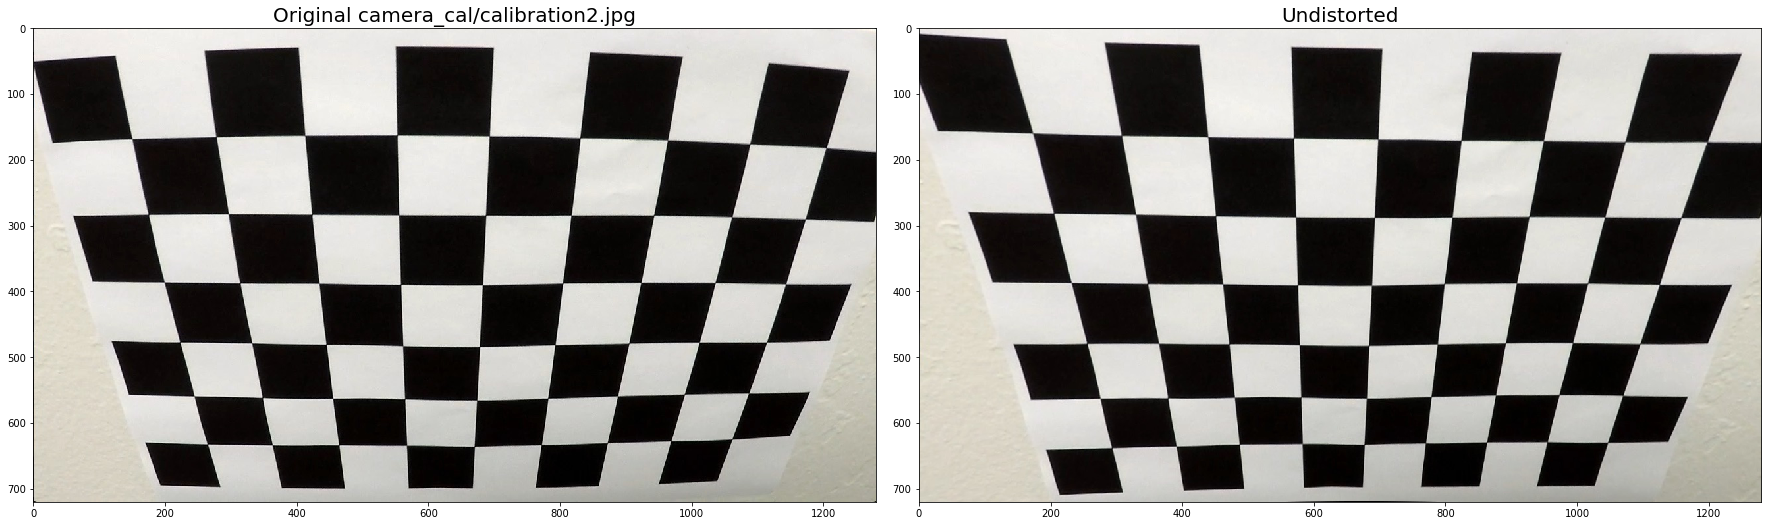

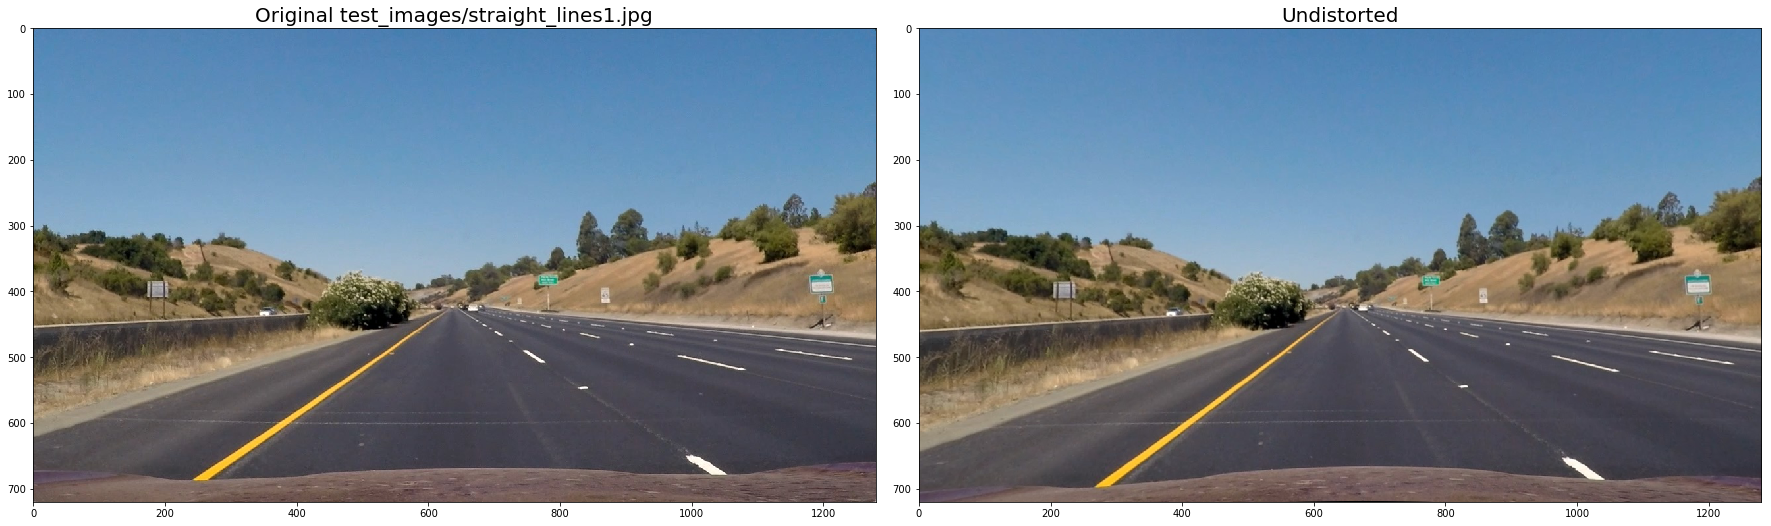

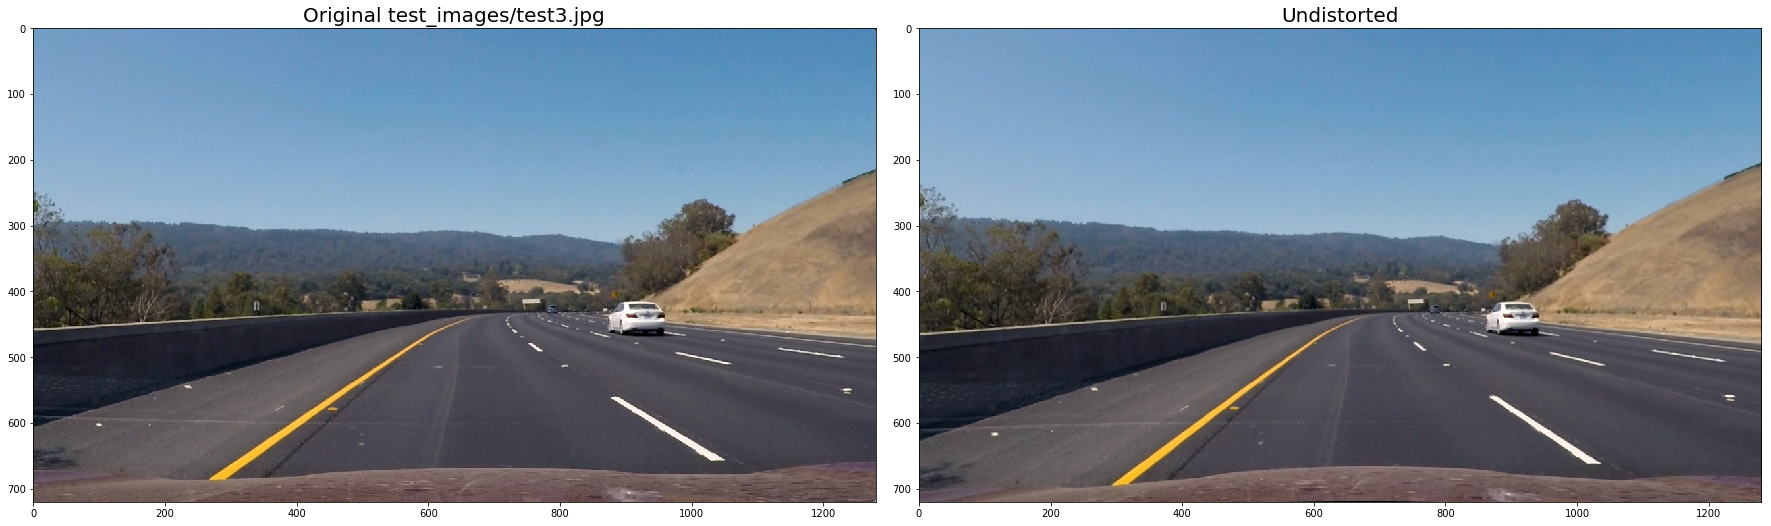

In [2]:
# Calibrate and test on multiple images
mtx, dist = calibrate_camera()
test_calibration(mtx, dist, 'camera_cal/calibration1.jpg')
test_calibration(mtx, dist, 'camera_cal/calibration2.jpg')
test_calibration(mtx, dist, 'test_images/straight_lines1.jpg')
test_calibration(mtx, dist, 'test_images/test3.jpg')

In [3]:
# Save undistort for further process
try:
    os.mkdir("output_images/undistorted")
except:
    pass

for image_file in os.listdir("test_images/"):    
    # Read in and grayscale the image
    image = mpimg.imread("test_images/" + image_file)     
    undist = undistort(image, mtx, dist)
    # cv2 has flipped bits - https://stackoverflow.com/questions/42406338/why-cv2-imwrite-changes-the-color-of-pics
    cv2.imwrite("output_images/undistorted/" + image_file, cv2.cvtColor(undist, cv2.COLOR_RGB2BGR))

## Pipeline for Static Images
My pipeline for Static Images includes the following steps:
1. Undistort image.
1. Create Threshold (color/gradient) Binary from undistroted image.
1. Perform Perspective Transform on Threshold Binary to convert it to birds-eye View.
1. In the birds-eye View of Threshold Binary, find lane lines using moving windows. Also calculate the radius of curvature and vehicle position. Fill the area within lane lines with solid color.
1. Perform Perspective to convert the Threshold Binary into the original view.
1. Overlay the Threshold Binary to the original image.
1. Plot radius of curvature and vehicle position calculated in step 4 at the top-left corner of the original image.

Next I am going to describe each step in detail. `test_images_undistorted/straight_lines1.jpg` is used to demonstrate effect of each step.

<center>Original Image</center>
<img src="test_images/straight_lines1.jpg" width="300"/>

### 1. Undistort Image
Undistort image using the camera matrix and distortation coefficients.

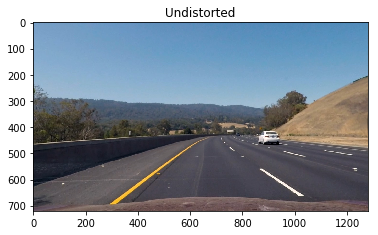

In [4]:
img = mpimg.imread('test_images/test3.jpg')
undist = undistort(img, mtx, dist)
plt.title('Undistorted')
plt.imshow(undist)

### 2. Threshold Binary based on Color/Gradient

Two different approaches have been considered for threshold binary -
1. Combination of x/y gradients and gradient magnitude
1. Combination of HLS color selection and x gradient 

Result in the block below suggets that `HLS color + x gradient` picks up more features from lane lines.

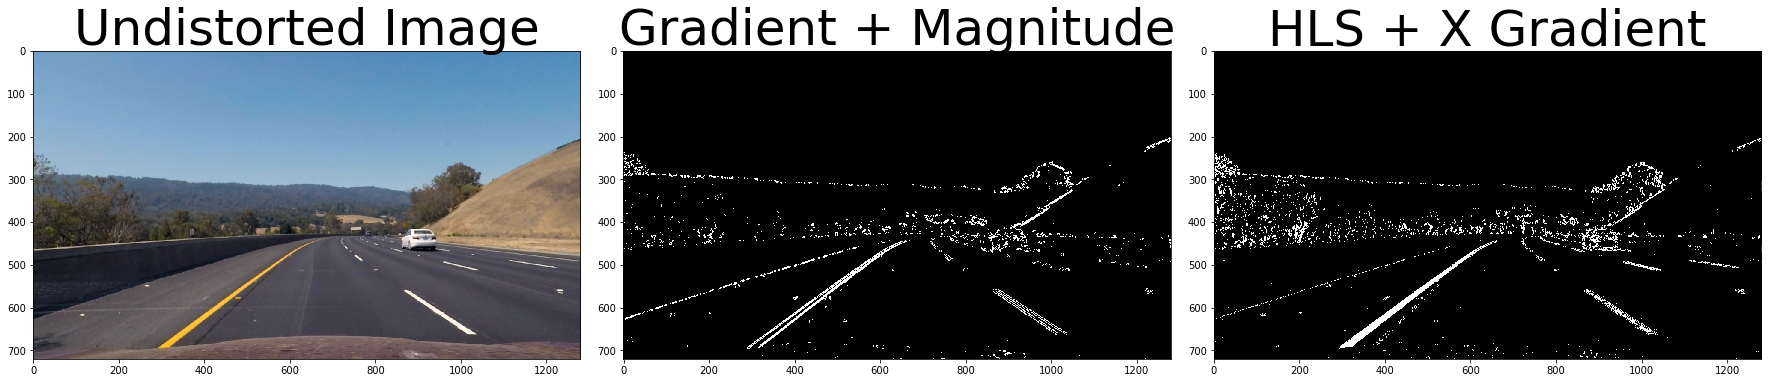

In [5]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def combined_gradient_mag(img):
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined
    
def combined_hls_gradient(img):
    # Threshold x gradient
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
    # Threshold color channel    
    s_binary = hls_select(img, (170, 255))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(s_binary == 1) | (gradx == 1)] = 1    
    return combined_binary
    
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=50)

threshold_binary = combined_gradient_mag(undist)
ax2.imshow(threshold_binary, cmap='gray')
ax2.set_title('Gradient + Magnitude', fontsize=50)

threshold_binary = combined_hls_gradient(undist)
ax3.imshow(threshold_binary, cmap='gray')
ax3.set_title('HLS + X Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### 3. Perform Perspective Transform to birds-eye View

A polygon, which in birds-view should be a perfect rectangle, is constructed by 
connecting the straight lane lines. The vertices of this polygon in camera view and birds-eye view are used to 
find the transform matrix.

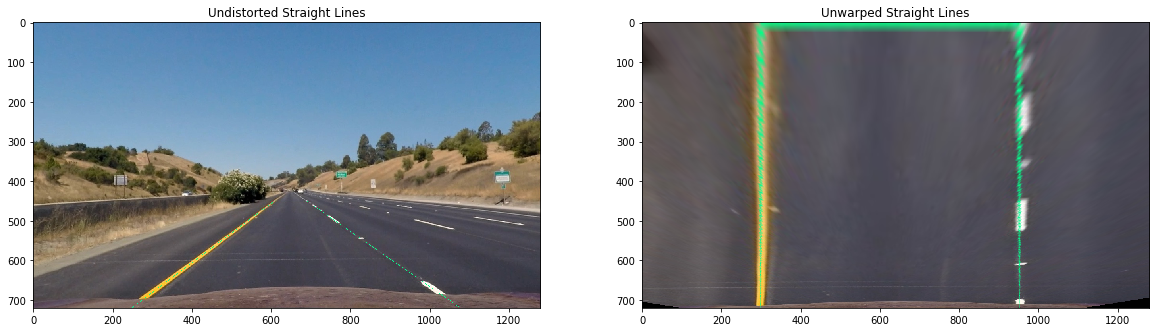

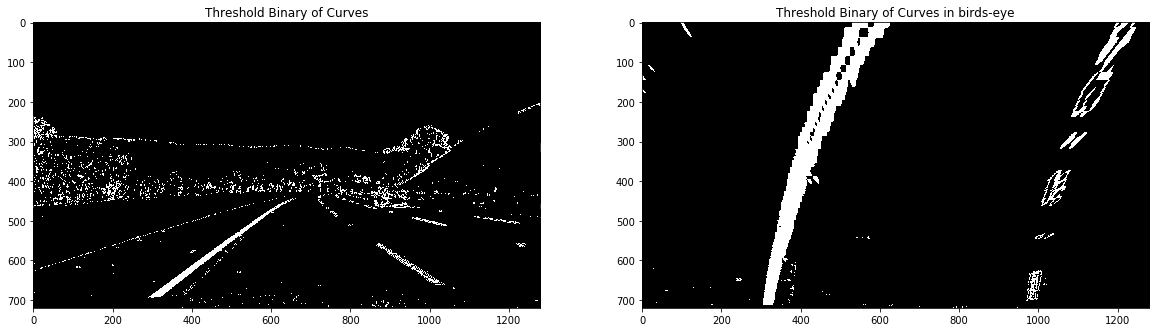

In [6]:
def perspective_transform_to_birds_eye(img):
    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 100 pixels is not exact, but close enough for our purpose here
    offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
        
    src = np.float32([(608, 450), (689, 450), (1077, 720), (249, 720)])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[300, 0], [950, 0], [950, img_size[1]], [300, img_size[1]]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    return M

def warp(img, M):
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped
    
# Use straight lines to get perspective transform matrix
undist_straight = mpimg.imread("output_images/perspective_transform/straight_lines1.jpg")
warp_to_birds_eye_M = perspective_transform_to_birds_eye(undist_straight)

# Warp to birds-eye view
unwarped_straight = warp(undist_straight, warp_to_birds_eye_M)
birds_eye = warp(threshold_binary, warp_to_birds_eye_M)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted Straight Lines')
ax1.imshow(undist_straight)
ax2.set_title('Unwarped Straight Lines')
ax2.imshow(unwarped_straight)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Threshold Binary of Curves')
ax1.imshow(threshold_binary, cmap='gray')
ax2.set_title('Threshold Binary of Curves in birds-eye')
ax2.imshow(birds_eye, cmap='gray')

### 4. Find lane-line pixels and fit their positions with a polynomial

Searching for the lane-line pixels is done from bottm to top. 

Firstly a histogram with two peaks is calculated to locate the bottom of both lanes.

Secondly a window of 200x80 is moved up along the lane lines to locate the next segment. In every substep, mean of the horizontal positions is calculated on pixels within the current window. This mean position will be used as horizontal center of the next window.

Finally pixels in these windows are used to fit two polynomilas - one for the left lane line and one for the right lane line.

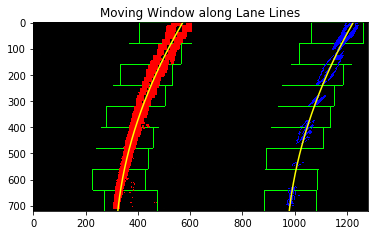

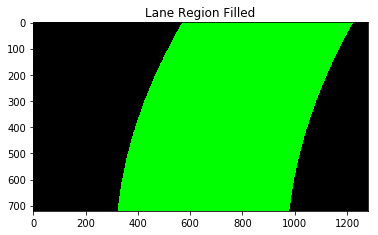

In [65]:
def find_lane_pixels(binary_warped, debug=False):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if debug:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped, xm_per_pix=1.0, ym_per_pix=1.0, debug=False):
    """Fit lane pixels in image to polynomials"""
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped, debug=debug)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    
    return left_fit, right_fit, leftx, lefty, rightx, righty, out_img

def fill_polynomial(binary_warped, left_fit, right_fit, debug=False):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    # Thanks to https://stackoverflow.com/questions/44990758/opencv-and-python-shading-area-between-two-lines
    h, w = binary_warped.shape[:2]
        
    left_points = np.array([[[xi, yi]] for xi, yi in zip(left_fitx, ploty) if (0<=xi<w and 0<=yi<h)]).astype(np.int32)
    right_points = np.array([[[xi, yi]] for xi, yi in zip(right_fitx, ploty) if (0<=xi<w and 0<=yi<h)]).astype(np.int32)
    right_points = np.flipud(right_points)
    points = np.concatenate((left_points, right_points))
    
    polynomialgon = binary_warped.copy()
    if debug:
        # Plots the left and right polynomials on the lane lines
        polynomialgon[lefty, leftx] = [255, 0, 0]
        polynomialgon[righty, rightx] = [0, 0, 255]
    
    cv2.fillPoly(polynomialgon, [points], color=[0,255,0])
        
    return polynomialgon

def test_polynomial(binary_warped):
    left_fit, right_fit, leftx, lefty, rightx, righty, out_img = fit_polynomial(binary_warped, debug=True)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
  
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

moving_window = test_polynomial(birds_eye)
plt.title('Moving Window along Lane Lines')
plt.imshow(moving_window)
left_fit, right_fit, leftx, lefty, rightx, righty, out_img = fit_polynomial(birds_eye, debug=False)
filled_poly = fill_polynomial(out_img, left_fit, right_fit, debug=False)
plt.figure()
plt.title('Lane Region Filled')
plt.imshow(filled_poly)

** After fitting polynominals in pixels, 

1. We try to calculte the radious of curvature in metre. **
For this project, we can assume that if we're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide. (https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/096009a1-3d76-4290-92f3-055961019d5e/concepts/1a352727-390e-469d-87ea-c91cd78869d6)

Thus we define the following convertion factors
```python
# Number of lane pixels in y dimenstion
num_pix_y = 720
# Number of lane pixels in x dimension (roughly 1000 - 300)
num_pix_x = 700
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/num_pix_y # meters per pixel in y dimension
xm_per_pix = 3.7/num_pix_x # meters per pixel in x dimension
```

2. We also try to calculate the vehicle position relative to the lane center. This is done by finding the lane 

Radius of Curvature in this image is 511.19 m
Vehicle positon from center is -0.06 m


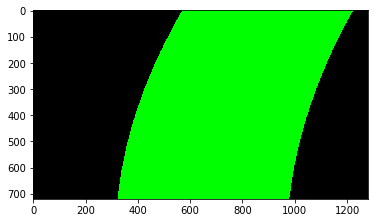

In [66]:
def measure_curvature(img, left_fit, right_fit, xm_per_pix=1.0, ym_per_pix=1.0):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image    
    y_eval = np.max(img.shape[0])
    left_curverad = np.power(1 + np.square(2 * left_fit[0] * y_eval * ym_per_pix + left_fit[1]), 1.5) / np.fabs(2 * left_fit[0])
    right_curverad = np.power(1 + np.square(2 * right_fit[0] * y_eval * ym_per_pix + right_fit[1]), 1.5) / np.fabs(2 * right_fit[0])
    radius = (left_curverad + right_curverad) / 2
    return radius

def measure_distance(img, left_fit, right_fit, xm_per_pix=1.0, ym_per_pix=1.0):
    '''
    Calculates the distance of vehicle to the center of original image. left -> negative, right->positive
    '''
    y = image.shape[0] * ym_per_pix
    # Find two x coordiantes at the bottom of image in transformed image
    left_x = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    right_x = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]    
    center_x = (left_x + right_x) / 2    
    
    center_x_image = image.shape[1] / 2 * xm_per_pix
    return center_x_image - center_x

# Number of lane pixels in y dimenstion
num_pix_y = 720
# Number of lane pixels in x dimension (roughly 1000 - 300)
num_pix_x = 700
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/num_pix_y # meters per pixel in y dimension
xm_per_pix = 3.7/num_pix_x # meters per pixel in x dimension
left_fit, right_fit, leftx, lefty, rightx, righty, out_img = \
    fit_polynomial(birds_eye, xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix, debug=False)

plt.imshow(filled_poly)
radius_m = measure_curvature(filled_poly, left_fit, right_fit, xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
print('Radius of Curvature in this image is {0:.2f} m'.format(radius_m))
distance_m = measure_distance(filled_poly, left_fit, right_fit, xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
print('Vehicle positon from center is {0:.2f} m'.format(distance_m))

### 5. Perform Perspective to convert the Filled Lane Area into the original view.

Using the same technique as in step 3, but this time we swap `src` and `dst` of the transform matrix. The output of `cv2.getPerspectiveTransform()` will transform an image from birds-eye view to the original camera view.

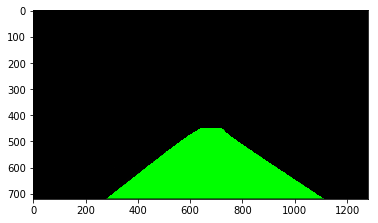

In [67]:
def perspective_transform_from_birds_eye(img):
    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 100 pixels is not exact, but close enough for our purpose here
    offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
        
    src = np.float32([(608, 450), (689, 450), (1077, 720), (249, 720)])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    dst = np.float32([[300, 0], [950, 0], [950, img_size[1]], [300, img_size[1]]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(dst, src)
    return M

warp_from_birds_eye_M = perspective_transform_from_birds_eye(filled_poly)
warped_from_birds_eye = warp(filled_poly, warp_from_birds_eye_M)

plt.imshow(warped_from_birds_eye)

### 6. Overlay the Filled Lane Area/Radius of Curvature/Vehicle Position to the original image
In this step we use the `weighted_img()` function from `CarND-LaneLines-P1` (https://github.com/udacity/CarND-LaneLines-P1)

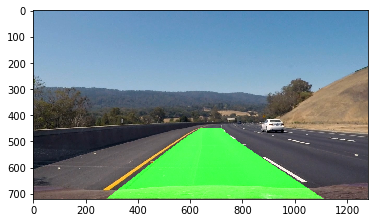

In [68]:
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

weighted = weighted_img(img, warped_from_birds_eye)
plt.figure()
plt.imshow(weighted)

### 7. Plot radius of curvature and vehicle position calculated in step 4

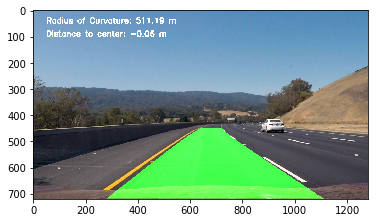

In [69]:
def plot_curvature(img, radius):
    '''
    Plot the curvature of polynomial functions in pixels.
    '''
    out_img = img.copy()
    cv2.putText(out_img, 'Radius of Curvature: {0:.2f} m'.format(radius), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4)    
    return out_img

def plot_distance(img, distance):
    '''
    Plot vehicle position offset to the center of lane.
    '''
    out_img = img.copy()
    cv2.putText(out_img, 'Distance to center: {0:.2f} m'.format(distance), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4)
    return out_img

weighted_curvature = plot_curvature(weighted, radius_m)
weighted_distance = plot_distance(weighted_curvature, distance_m)
plt.figure()
plt.imshow(weighted_distance)

**With the components above, we can easily build up a pipeline to process static images.**

In [39]:
def pipeline(img):
    undist = undistort(img, mtx, dist)
    threshold_binary = combined_hls_gradient(undist)
    birds_eye = warp(threshold_binary, warp_to_birds_eye_M)
    left_fit, right_fit, _, _, _, _, out_img = \
        fit_polynomial(birds_eye, debug=False)
    filled_poly = fill_polynomial(out_img, left_fit, right_fit)    
    warped_from_birds_eye = warp(filled_poly, warp_from_birds_eye_M)    
    weighted = weighted_img(img, warped_from_birds_eye)
    
    # Poly fit with real world metrics
    left_fit_m, right_fit_m, _, _, _, _, _ = \
        fit_polynomial(birds_eye, xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix, debug=False)
    radius_m = measure_curvature(filled_poly, left_fit_m, right_fit_m, xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
    distance_m = measure_distance(filled_poly, left_fit_m, right_fit_m, xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix)
    weighted_curvature = plot_curvature(weighted, radius_m)
    weighted_distance = plot_distance(weighted_curvature, distance_m)

    return weighted_distance

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

try:
    os.mkdir("test_videos_output")
except:
    pass

def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes) 
    return pipeline(img)

video_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
clip_processed = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time clip_processed.write_videofile(video_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


 89%|████████▉ | 1121/1261 [03:07<00:23,  5.99it/s]

KeyboardInterrupt: 